# Overview

In [1]:
# Import libraries
# yfinance offers a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance
# Please check out its official doc for details: https://pypi.org/project/yfinance/
import yfinance as yf
import pandas as pd

# Load historical data in the past 10 years
sp500 = yf.Ticker("^GSPC")
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=10*365)
sp500_history=sp500.history(start=start_date, end=end_date)

# Remove unnecessary columns
sp500_history = sp500_history.drop(columns=['Dividends', 'Stock Splits'])

# Create a new column as Close 200 days moving average
sp500_history['Close_200ma'] = sp500_history['Close'].rolling(200).mean()

# Create a summary statistics table
sp500_history_summary = sp500_history.describe()

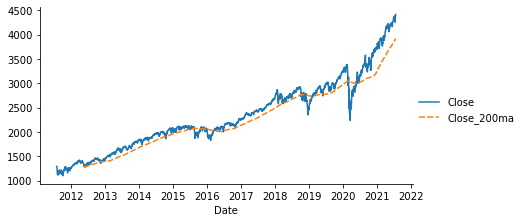

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.relplot(data=sp500_history[['Close', 'Close_200ma']], kind='line', height=3, aspect=2.0)
plt.savefig('chart.png')

# Excel

In [3]:
# Import libraries
from openpyxl.chart import LineChart, Reference

# 1. Set up an ExcelWriter
with pd.ExcelWriter('excel_report.xlsx', engine='openpyxl') as writer:
# 2. Export data
    sp500_history.to_excel(writer, sheet_name='historical_data')
    sp500_history_summary.to_excel(writer, sheet_name='historical_data_summary')
    
# 3. Add a line chart
    # Point to the sheet 'historical_data', where the chart will be added
    wb = writer.book 
    ws = wb['historical_data'] 
    # Grab the maximum row number in the sheet
    max_row = ws.max_row
    # Refer to the data of close and close_200ma by the range of rows and cols on the sheet
    values_close = Reference(ws, min_col=5, min_row=1, max_col=5, max_row=max_row)
    values_close_ma = Reference(ws, min_col=7, min_row=1, max_col=7, max_row=max_row)
    # Refer to the date
    dates = Reference(ws, min_col=1, min_row=2, max_col=1, max_row=max_row)
    # Create a LineChart
    chart = LineChart()
    # Add data of close and close_ma to the chart
    chart.add_data(values_close, titles_from_data=True)
    chart.add_data(values_close_ma, titles_from_data=True)
    # Set the dates as the x axis and format it
    chart.set_categories(dates)
    chart.x_axis.number_format = 'mmm-yy'
    chart.x_axis.majorTimeUnit = 'days'
    chart.x_axis.title = 'Date'
    # Add title to the chart
    chart.title = 'Close prices of S&P 500'
    # Refer to close_ma data, which is with index 1 within the chart, and style it
    s1 = chart.series[1]
    s1.graphicalProperties.line.dashStyle = 'sysDot'
    # Add the chart to the cell of G12 on the sheet ws
    ws.add_chart(chart, 'G12')

# HTML

### HTML

In [4]:
# 1. Set up multiple variables to store the titles, text within the report
page_title_text='My report'
title_text = 'Daily S&P 500 prices report'
text = 'Hello, welcome to your report!'
prices_text = 'Historical prices of S&P 500'
stats_text = 'Historical prices summary statistics'


# 2. Combine them together using a long f-string
html = f'''
    <html>
        <head>
            <title>{page_title_text}</title>
        </head>
        <body>
            <h1>{title_text}</h1>
            <p>{text}</p>
            <img src='chart.png' width="700">
            <h2>{prices_text}</h2>
            {sp500_history.tail(3).to_html()}
            <h2>{stats_text}</h2>
            {sp500_history_summary.to_html()}
        </body>
    </html>
    '''
# 3. Write the html string as an HTML file
with open('html_report.html', 'w') as f:
    f.write(html)

### HTML with template

In [5]:
# 1. Create a template file as report_template.html

from jinja2 import Environment, FileSystemLoader

# 2. Create a template Environment
env = Environment(loader=FileSystemLoader('templates'))

# 3. Load the template from the Environment
template = env.get_template('report_template.html')

# 4. Render the template with variables
html = template.render(page_title_text='My report',
                       title_text='Daily S&P 500 prices report',
                       text ='Hello, welcome to your report!',
                       prices_text='Historical prices of S&P 500',
                       stats_text='Historical prices summary statistics',
                       sp500_history=sp500_history,
                       sp500_history_summary=sp500_history_summary)

# 5. Write the template to an HTML file
with open('html_report_jinja.html', 'w') as f:
    f.write(html)

### HTML to PDF

In [6]:
from weasyprint import HTML, CSS
css = CSS(string='''
    @page {size: A4; margin: 1cm;} 
    th, td {border: 1px solid black;}
    ''')
HTML('html_report_jinja.html').write_pdf('weasyprint_pdf_report.pdf', stylesheets=[css])

# PDF

In [7]:
def output_df_to_pdf(pdf, df):
    # A cell is a rectangular area, possibly framed, which contains some text
    # Set the width and height of cell
    table_cell_width = 25
    table_cell_height = 6
    # Select a font as Arial, bold, 8
    pdf.set_font('Arial', 'B', 8)
    
    # Loop over to print column names
    cols = df.columns
    for col in cols:
        pdf.cell(table_cell_width, table_cell_height, col, align='C', border=1)
    # Line break
    pdf.ln(table_cell_height)
    # Select a font as Arial, regular, 10
    pdf.set_font('Arial', '', 10)
    # Loop over to print each data in the table
    for row in df.itertuples():
        for col in cols:
            value = str(getattr(row, col))
            pdf.cell(table_cell_width, table_cell_height, value, align='C', border=1)
        pdf.ln(table_cell_height)

In [8]:
from fpdf import FPDF

# 1. Set up the PDF doc basics
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)

# 2. Layout the PDF doc contents
## Title
pdf.cell(40, 10, 'Daily S&P 500 prices report')
## Line breaks
pdf.ln(20)
## Image
pdf.image('chart.png')
## Line breaks
pdf.ln(20)
## Show table of historical data
### Transform the DataFrame to include index of Date
sp500_history_pdf = sp500_history.reset_index()
### Transform the Date column as str dtype
sp500_history_pdf['Date'] = sp500_history_pdf['Date'].astype(str)
### Round the numeric columns to 2 decimals
numeric_cols = sp500_history_pdf.select_dtypes(include='number').columns
sp500_history_pdf[numeric_cols] = sp500_history_pdf[numeric_cols].round(2)
### Use the function defined earlier to print the DataFrame as a table on the PDF 
output_df_to_pdf(pdf, sp500_history_pdf.tail(3))
## Line breaks
pdf.ln(20)
## Show table of historical summary data
sp500_history_summary_pdf = sp500_history_summary.reset_index()
numeric_cols = sp500_history_summary_pdf.select_dtypes(include='number').columns
sp500_history_summary_pdf[numeric_cols] = sp500_history_summary_pdf[numeric_cols].round(2)

output_df_to_pdf(pdf, sp500_history_summary_pdf)
# 3. Output the PDF file
pdf.output('fpdf_pdf_report.pdf', 'F')

''